In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

In [175]:
def update(T_k, T_0):
    
    T_kP1 = T_0.copy()
    
    length = len(T_k)
    width = len(T_k[0].A1)
    
    for i in range(1, length - 1):
        for j in range(1, width - 1):
            ## i and j now index the entire inside of the array and does not touch any of the edges
            
            T_kP1[i,j] += 1/4*(T_k[i,j+1] + T_k[i,j-1] + T_k[i+1,j] + T_k[i-1,j])
    
    return T_kP1

def update_with_source(T_k, T_0, q, h):
    # This new update function will use the fact that there will be a source term at each of the points
    # it will also update the new T_0 with the BC
    
    T_kP1 = T_0.copy()
    
    length = len(T_k)
    width = len(T_k[0].A1)
    
    for i in range(1, length - 1):
        for j in range(1, width - 1):
            ## i and j now index the entire inside of the array and does not touch any of the edges
            
            # q is in terms of W/mm^3 and we want W/stepsize^3 therefore we divide by 1e3
            T_kP1[i,j] += 1/4*(T_k[i,j+1] + T_k[i,j-1] + T_k[i+1,j] + T_k[i-1,j]) + 1/4 * q * h **2 /K_si
            
    T_0_new = update_processor_boundary(T_kP1, T_0)
    
    return T_kP1, T_0_new

def initialise_boundary(top, left, right, bottom, T_ambient, corners=[0,0,0,0], Get_T_K=True):
    cols = len(top)+2
    rows = len(left)+2
    
    middle_zeros = np.array([0 for i in top])
    
    if Get_T_K:
        middle_ambient = np.array([T_ambient for i in top])
    
    if corners == [0,0,0,0]:
        initial_top = np.append(np.append([(top[0]+left[0])/2],top), [(top[-1]+right[0])/2])
        initial_bottom = np.append(np.append([(bottom[0]+left[-1])/2],bottom), [(bottom[-1]+right[-1])/2])
    else:
        initial_top = np.append(np.append([corners[0]],top), [corners[1]])
        initial_bottom = np.append(np.append([corners[2]],bottom), [corners[3]])
    
    
    
    middle = np.array(np.append([np.append(np.append([left[i]], middle_zeros), [right[i]]) for i in range(rows-2)],[]))
    
    if Get_T_K:
        middle_ambient = np.array(np.append([np.append(np.append([left[i]], middle_ambient), [right[i]]) for i in range(rows-2)],[]))
    
    initial_array = np.append(np.append(initial_top, middle), initial_bottom)
    initial_matrix_T_0 = np.matrix(initial_array.reshape(rows, cols))
    
    if Get_T_K:
        initial_array = np.append(np.append(initial_top, middle_ambient), initial_bottom)
        initial_matrix_T_k = np.matrix(initial_array.reshape(rows, cols))
        return initial_matrix_T_0, initial_matrix_T_k
    
    
    return initial_matrix_T_0

def update_processor_boundary(T_k, T_0):
    # Take in T_k wich has a border of imaginary values
    # We want to update every value on the T_0 boundary
    # This is done by taking the value of T_k at the boundary (1 before the imagniary points)
    # Then calculating the gradient due to natural convection
    # Then creating new imaginary points which are then used to update the T_0
    
    T_a = 293
    K_si = 150
    h = 1e-4
    
    rows = len(T_k)
    cols = len(T_k[0].A1)
    
    # we will do the top first
    top = T_k[1].A1[1:-1] # get rid of the end terms with the [1:-1] term
    second_top = T_k[2].A1[1:-1]
    grad_top = np.array([gradient_nat_convection(i, T_a, K_si, h) for i in top]) 
    new_top = new_imaginary_points(grad_top, second_top, h)
    
    col_list = T_k.transpose()
    left = col_list[1].A1[1:-1]
    second_left = col_list[2].A1[1:-1]
    grad_left = np.array([gradient_nat_convection(i, T_a, K_si, h) for i in left])
    new_left = new_imaginary_points(grad_left, second_left, h)
    
    bottom = T_k[-2].A1[1:-1]
    second_bottom = T_k[-3].A1[1:-1]
    grad_bottom = np.array([gradient_nat_convection(i, T_a, K_si, h) for i in bottom])
    new_bottom = new_imaginary_points(grad_bottom, second_bottom, h)
    
    right = col_list[-2].A1[1:-1]
    second_right = col_list[-3].A1[1:-1]
    grad_right = np.array([gradient_nat_convection(i, T_a, K_si, h) for i in right])
    new_right = new_imaginary_points(grad_right, second_right,  h)
    
    T_0_new = initialise_boundary(new_top, new_left, new_right, new_bottom, T_a, [0,0,0,0], Get_T_K=False)
    return T_0_new
        
def new_imaginary_points(grad, previous_points, h):
    return previous_points + 2*h*grad # as gradient returned is negative and we know new imaginary points will be lower temp
        
    
def gradient_nat_convection(T_k_i, T_ambient, k_silicon, h):
    #print(T_k_i, (T_k_i - 1)**(4/3))
    #input()
    #value = - 1.31 * (T_ambient)**(1/3) * (T_k_i - 1)**(4/3)   / (k_silicon*1e4) / (h**2)
    value = -1.31 * (T_ambient)**(1/3)/ k_silicon * (T_k_i-1)**(4/3)
    #print(value)
    return value



In [28]:
(1.9-1)**(4/3)*1.15*(300)**(1/3)/(150*1e4)/1e-4

T_k = np.matrix([[1,2,3],
                [2,3,4],
                [5,9,7]])

type(T_k[2].A1)
(1.1-1)**(4/3)*1.15*(300)**(1/3)/(150)

T_k[-2]

matrix([[2, 3, 4]])

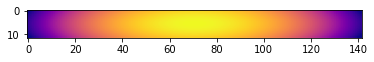

137.05934527889406 104.05934527889406


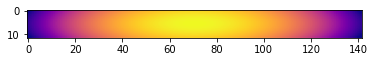

139.03199922885733 1.9726539499632736


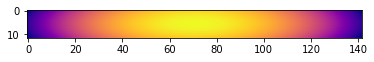

141.00367628882591 1.9716770599685844


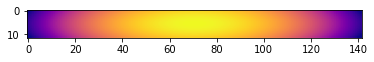

142.97437232832084 1.970696039494925


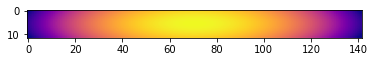

144.94408326811572 1.9697109397948793


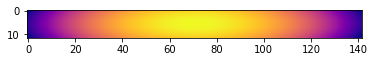

146.91280507922244 1.9687218111067182


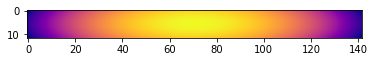

148.8805337819004 1.9677287026779595


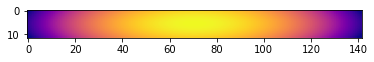

150.847265444697 1.9667316627966045


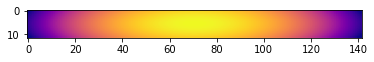

152.8129961835165 1.9657307388195022


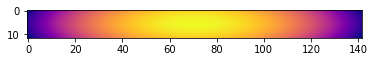

154.777722160716 1.9647259771994925


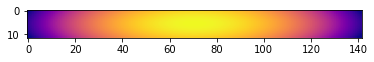

156.74143958422047 1.9637174235044768


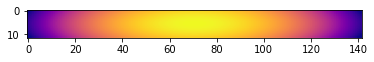

158.70414470667632 1.9627051224558443


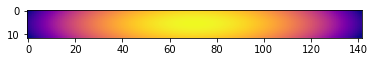

160.6658338246193 1.9616891179429956


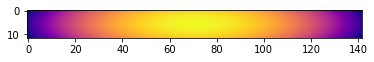

162.62650327766843 1.960669453049121


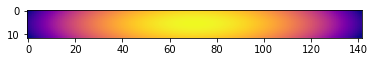

164.58614944774476 1.9596461700763257


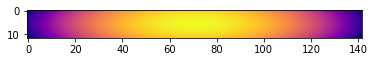

166.54476875831264 1.958619310567883


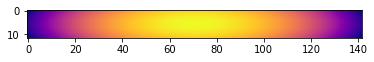

168.50235767364245 1.9575889153298078


KeyboardInterrupt: 

In [176]:
#top = np.array([1 for i in range(140)])
#bottom = top.copy()
#left = np.array([1 for i in range(10)])
#right = left.copy()
#ambient = 33
#T_0, T_k = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])
q = 0.5*1e9
T_a = 293
K_si = 150
h = 1e-4

#T_k_updated, T_0_updated = update_with_source(T_k, T_0, q, 1e-4)
avT_k_1 = ambient
diff_array = []
av_array = []

for i in range(10000):
    T_k_updated, T_0_updated = update_with_source(T_k_updated, T_0_updated, q, 1e-4)
    if i%250 == 0:
        fig, ax = plt.subplots()
        im = ax.imshow(T_k_updated, cmap='plasma')
        plt.show()
        #fig.suptitle('Temperature map')
        #cbar = ax.figure.colorbar(im, orientation='horizontal')
        #cbar.ax.set_xlabel('Temperature Scale')
        #plt.show()
        avT_k = sum(T_k_updated.ravel().A1)/(len(T_k_updated)*len(T_k_updated[1].A1))
        diff = avT_k-avT_k_1
        print(avT_k, diff)
        avT_k_1 = avT_k
    if i%100 == 0 and i >= 2000:
        diff_array.append(diff)
        av_array.append(avT_k)




In [33]:
a = np.linspace(0,10,11)
b = np.array([5 for i in range(11)])
a-b
(20-1)**(4/3)*1.15*(300)**(1/3)/(150)

2.602066955428068

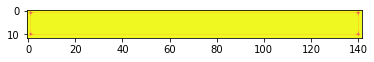

6.529040694797647 -0.47095930520235285


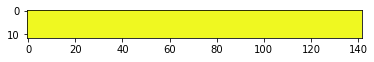

6.653548852329456 0.12450815753180855


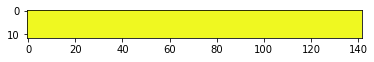

6.654008879690319 0.0004600273608632577


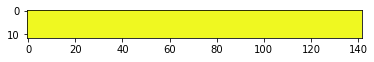

6.654147995189003 0.00013911549868428352


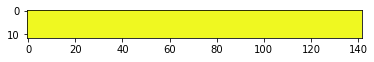

6.654183663527658 3.566833865509267e-05


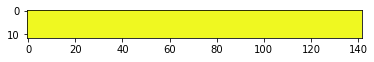

6.654170813218624 -1.2850309034639906e-05


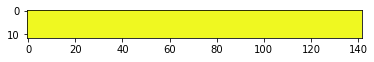

6.6541306696226314 -4.014359599224804e-05


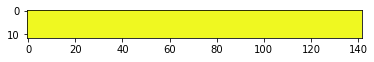

6.654073385643783 -5.72839788484103e-05


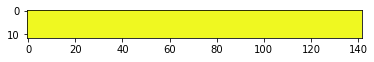

6.654004492822681 -6.889282110211781e-05


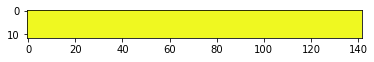

6.653927278089175 -7.721473350574826e-05


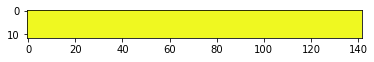

6.6538438203617725 -8.345772740270263e-05


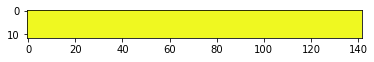

6.653755501133754 -8.831922801810776e-05


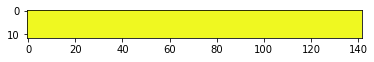

6.653663278929387 -9.222220436733153e-05


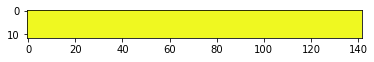

6.653567845953023 -9.543297636405157e-05


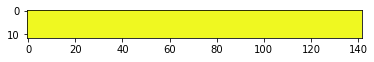

6.653469721169872 -9.81247831512988e-05


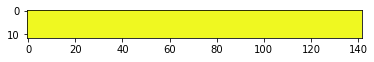

6.653369307196522 -0.00010041397334958901


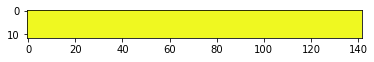

6.653266925860265 -0.00010238133625684043


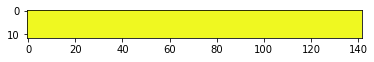

6.653162840900498 -0.0001040849597675475


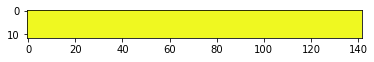

6.65305727279412 -0.00010556810637751823


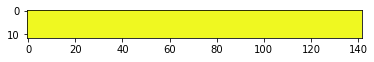

6.652950408693367 -0.00010686410075333441


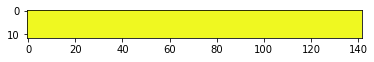

6.652842409288657 -0.0001079994047099575


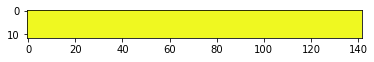

6.652733413706324 -0.00010899558233301576


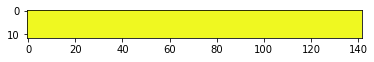

6.6526235431269045 -0.00010987057941935774


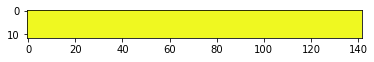

6.652512903550252 -0.00011063957665236046


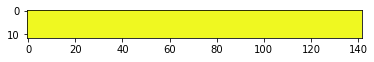

6.652401587975278 -0.00011131557497456868


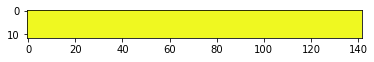

6.652289678165455 -0.00011190980982256349


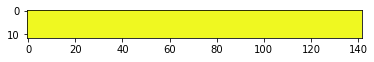

6.652177246111188 -0.00011243205426669789


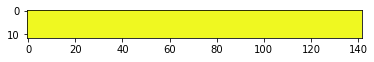

6.652064355262186 -0.000112890849002234


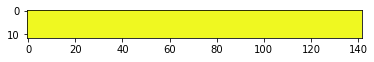

6.651951061579802 -0.00011329368238399695


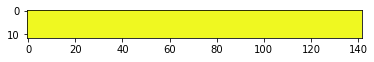

6.65183741444483 -0.00011364713497208356


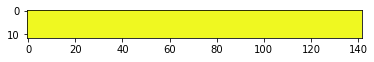

6.651723457445855 -0.00011395699897498446


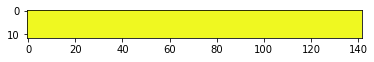

6.651609229067533 -0.00011422837832242294


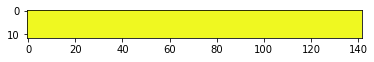

6.6514947632935915 -0.00011446577394114144


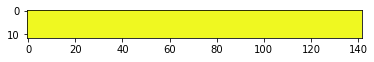

6.651380090136647 -0.00011467315694435598


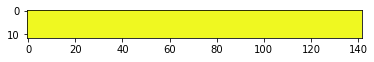

6.651265236103871 -0.0001148540327760017


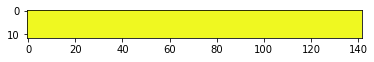

6.651150224608003 -0.00011501149586834458


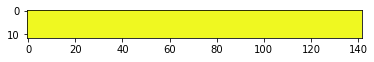

6.651035076329069 -0.0001151482789341074


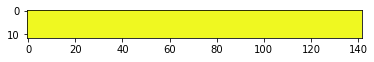

6.650919809533753 -0.00011526679531570494


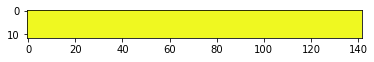

6.650804440357347 -0.00011536917640597721


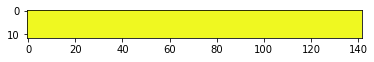

6.650688983052526 -0.00011545730482076522


In [132]:
top = np.array([1 for i in range(140)])
bottom = top.copy()
left = np.array([1 for i in range(10)])
right = left.copy()
ambient = 7
T_0, T_k = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])
q = 0.001

T_k_updated, T_0_updated = update_with_source(T_k, T_0, q, 1e-4)
avT_k_1 = ambient
diff_array = []
av_array = []

for i in range(10000):
    T_k_updated, T_0_updated = update_with_source(T_k_updated, T_0_updated, q, 1e-4)
    if i%250 == 0:
        fig, ax = plt.subplots()
        im = ax.imshow(T_k_updated, cmap='plasma', vmin=1, vmax=5)
        plt.show()
        #fig.suptitle('Temperature map')
        #cbar = ax.figure.colorbar(im, orientation='horizontal')
        #cbar.ax.set_xlabel('Temperature Scale')
        #plt.show()
        avT_k = sum(T_k_updated.ravel().A1)/(len(T_k_updated)*len(T_k_updated[1].A1))
        diff = avT_k-avT_k_1
        print(avT_k, diff)
        avT_k_1 = avT_k
    if i%100 == 0 and i >= 2000:
        diff_array.append(diff)
        av_array.append(avT_k)

        

[[23.85450131 23.85450131 29.59343553 ... 29.59343553 23.85450131
  23.85450131]
 [23.85450131 14.876875   21.8146875  ... 21.8146875  14.876875
  23.85450131]
 [29.59343553 21.8146875  33.3775     ... 33.3775     21.8146875
  29.59343553]
 ...
 [29.59343553 21.8146875  33.3775     ... 33.3775     21.8146875
  29.59343553]
 [23.85450131 14.876875   21.8146875  ... 21.8146875  14.876875
  23.85450131]
 [23.85450131 23.85450131 29.59343553 ... 29.59343553 23.85450131
  23.85450131]]


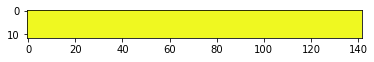

33.62276610302439 -4.377233896975611


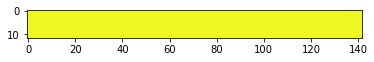

8.87608058575599 -24.7466855172684


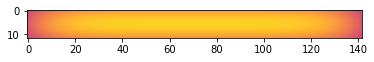

4.008514560668875 -4.867566025087115


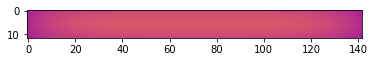

2.5415942449911784 -1.4669203156776964


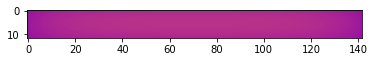

1.9896041971553031 -0.5519900478358752


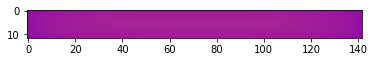

1.7541092177452589 -0.23549497941004427


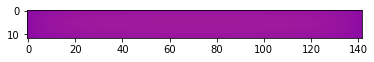

1.646372853950948 -0.10773636379431095


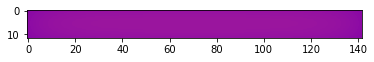

1.595195160782843 -0.05117769316810494


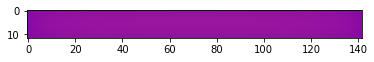

1.5704001605828724 -0.024795000199970607


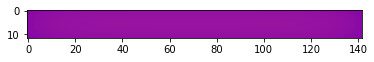

1.558264236398114 -0.012135924184758284


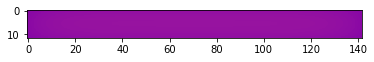

1.55229299059955 -0.005971245798564118


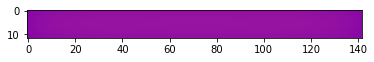

1.5493468834543667 -0.0029461071451832854


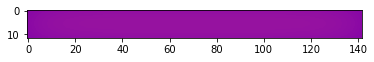

1.547891192038326 -0.0014556914160406276


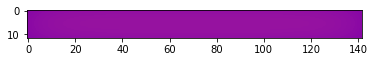

1.547171337765269 -0.0007198542730570967


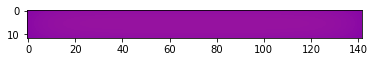

1.5468151916579993 -0.00035614610726963924


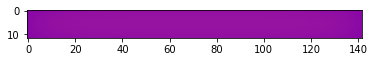

1.5466389361050397 -0.00017625555295963657


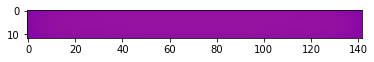

1.5465516900265026 -8.724607853705102e-05


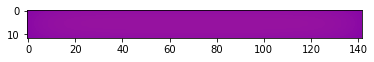

1.5465084970689735 -4.3192957529081255e-05


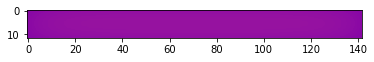

1.5464871111109866 -2.138595798695242e-05


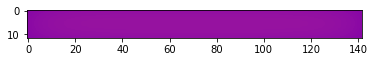

1.5464765214234324 -1.0589687554185545e-05


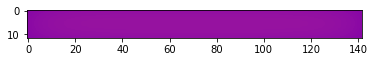

1.546471277346025 -5.24407740742916e-06


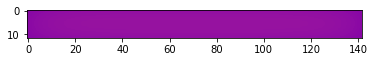

1.5464686802909609 -2.5970550641130075e-06


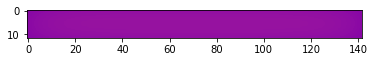

1.546467394071447 -1.2862195137852694e-06


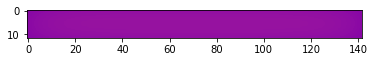

1.5464667570303232 -6.370411238521001e-07


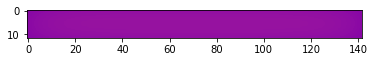

1.5464664415041198 -3.1552620338715087e-07


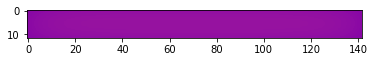

1.5464662852193536 -1.562847662395228e-07


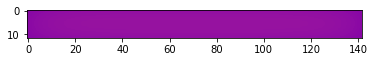

1.5464662078072255 -7.741212804113218e-08


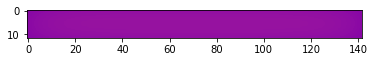

1.546466169462021 -3.834520456713619e-08


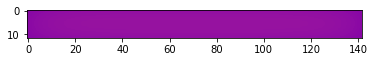

1.54646615046782 -1.8994200878807987e-08


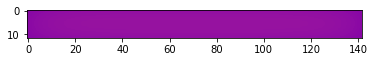

1.5464661410589429 -9.40887723288597e-09


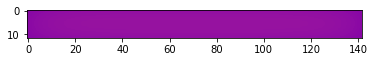

1.5464661363981385 -4.660804409084562e-09


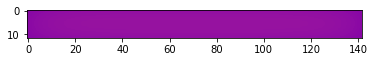

1.5464661340893298 -2.3088086997802293e-09


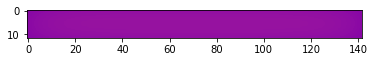

1.5464661329456073 -1.1437224500809862e-09


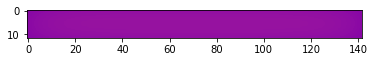

1.5464661323790365 -5.665707902835493e-10


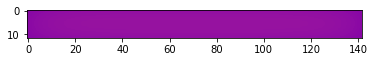

1.5464661320983657 -2.806708199187824e-10


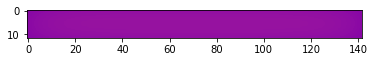

1.546466131959325 -1.390407788903758e-10


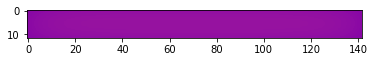

1.5464661318904434 -6.888156711681859e-11


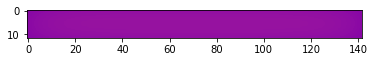

1.5464661318563286 -3.4114711056076885e-11


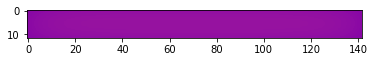

1.5464661318394244 -1.6904255772942633e-11


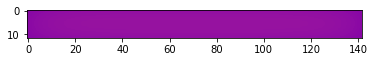

1.5464661318310482 -8.376188631586956e-12


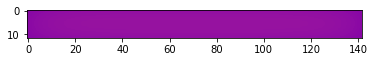

1.5464661318269017 -4.146460952370035e-12


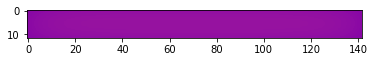

1.546466131824839 -2.062794379753541e-12


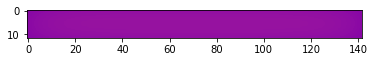

1.5464661318238264 -1.0125233984581428e-12


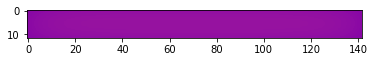

1.546466131823322 -5.044853423896711e-13


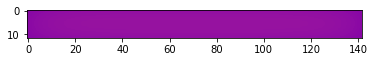

1.5464661318230726 -2.4935609133081016e-13


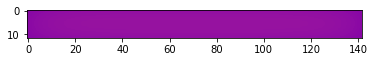

1.5464661318229462 -1.2634338020234281e-13


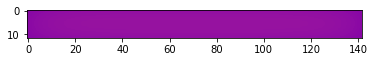

1.5464661318228896 -5.6621374255882984e-14


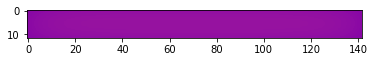

1.546466131822863 -2.6645352591003757e-14


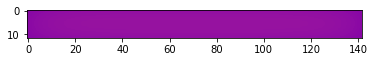

1.546466131822852 -1.0880185641326534e-14


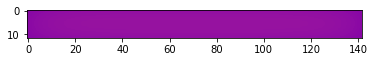

1.546466131822851 -1.1102230246251565e-15


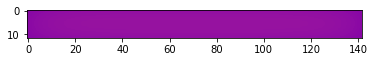

1.546466131822851 0.0


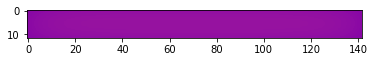

1.546466131822851 0.0


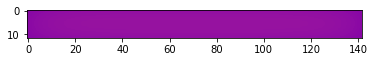

1.546466131822851 0.0


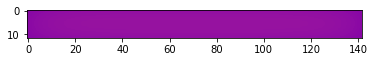

1.546466131822851 0.0


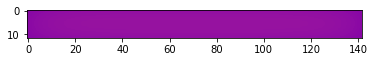

1.546466131822851 0.0


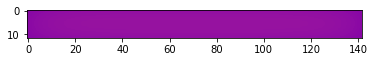

1.546466131822851 0.0


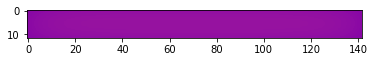

1.546466131822851 0.0


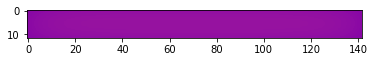

1.546466131822851 0.0


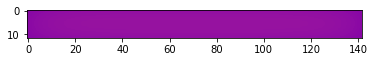

1.546466131822851 0.0


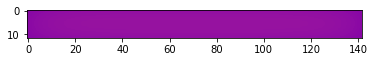

1.546466131822851 0.0


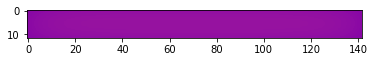

1.546466131822851 0.0


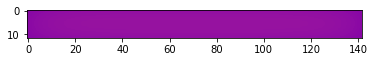

1.546466131822851 0.0


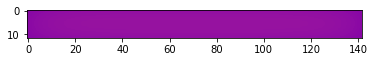

1.546466131822851 0.0


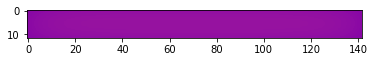

1.546466131822851 0.0


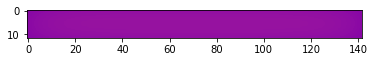

1.546466131822851 0.0


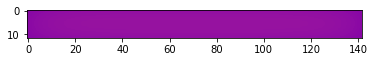

1.546466131822851 0.0


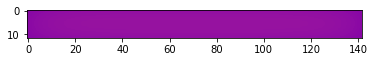

1.546466131822851 0.0


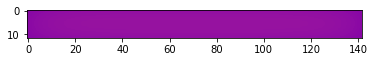

1.546466131822851 0.0


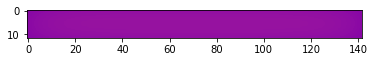

1.546466131822851 0.0


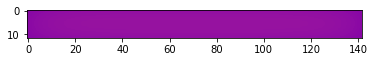

1.546466131822851 0.0


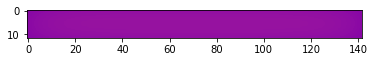

1.546466131822851 0.0


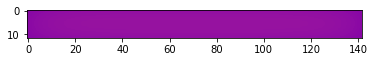

1.546466131822851 0.0


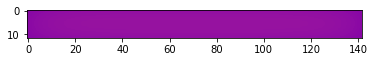

1.546466131822851 0.0


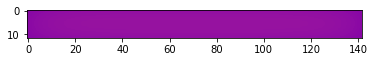

1.546466131822851 0.0


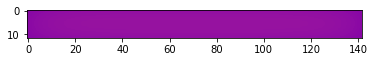

1.546466131822851 0.0


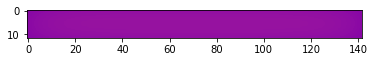

1.546466131822851 0.0


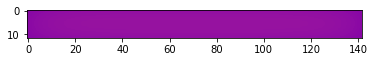

1.546466131822851 0.0


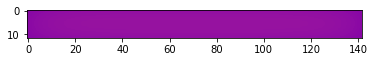

1.546466131822851 0.0


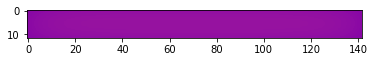

1.546466131822851 0.0


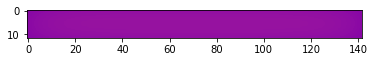

1.546466131822851 0.0


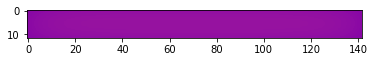

1.546466131822851 0.0


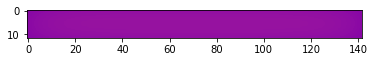

1.546466131822851 0.0


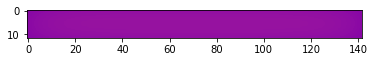

1.546466131822851 0.0


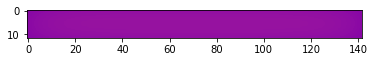

1.546466131822851 0.0


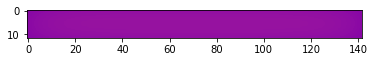

1.546466131822851 0.0


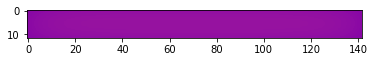

1.546466131822851 0.0


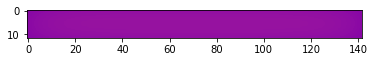

1.546466131822851 0.0


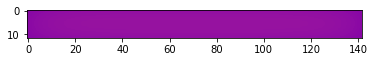

1.546466131822851 0.0


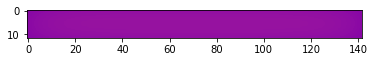

1.546466131822851 0.0


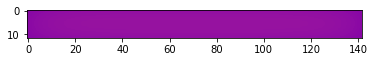

1.546466131822851 0.0


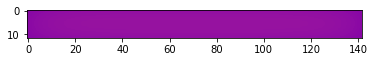

1.546466131822851 0.0


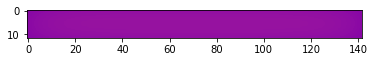

1.546466131822851 0.0


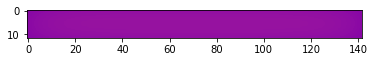

1.546466131822851 0.0


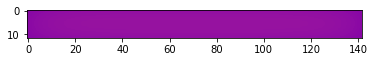

1.546466131822851 0.0


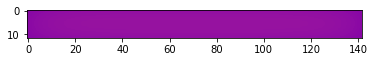

1.546466131822851 0.0


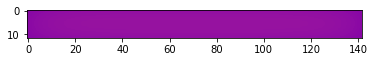

1.546466131822851 0.0


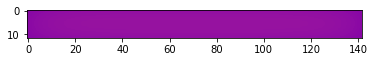

1.546466131822851 0.0


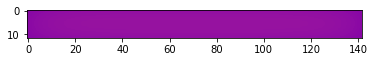

1.546466131822851 0.0


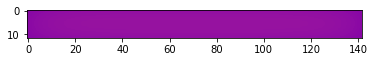

1.546466131822851 0.0


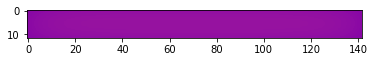

1.546466131822851 0.0


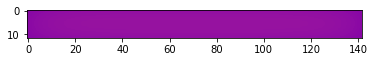

1.546466131822851 0.0


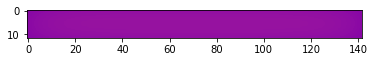

1.546466131822851 0.0


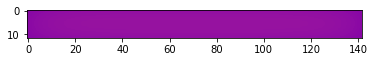

1.546466131822851 0.0


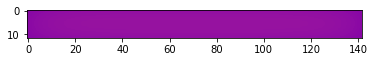

1.546466131822851 0.0


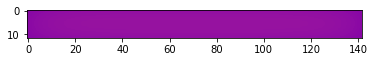

1.546466131822851 0.0


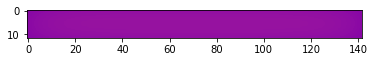

1.546466131822851 0.0


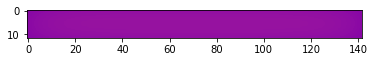

1.546466131822851 0.0


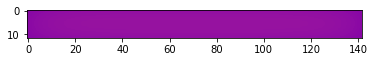

1.546466131822851 0.0


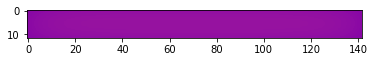

1.546466131822851 0.0


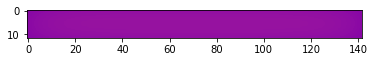

1.546466131822851 0.0


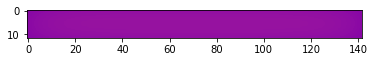

1.546466131822851 0.0


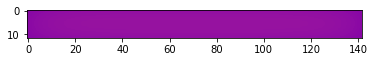

1.546466131822851 0.0


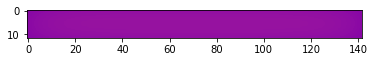

1.546466131822851 0.0


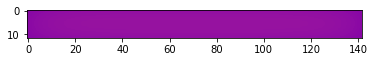

1.546466131822851 0.0


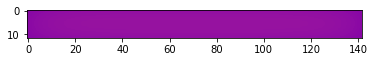

1.546466131822851 0.0


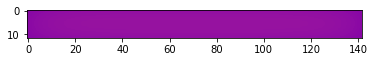

1.546466131822851 0.0


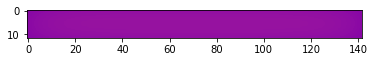

1.546466131822851 0.0


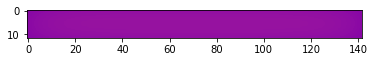

1.546466131822851 0.0


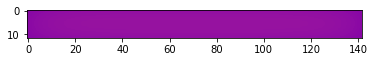

1.546466131822851 0.0


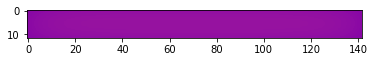

1.546466131822851 0.0


In [169]:
top = np.array([1 for i in range(140)])
bottom = top.copy()
left = np.array([1 for i in range(10)])
right = left.copy()
ambient = 38

T_0, T_k = initialise_boundary(top, left, right, bottom, ambient,[ambient,ambient,ambient,ambient])
q = 0.5

T_k_updated, T_0_updated = update_with_source(T_k, T_0, q, 1e-4)
avT_k_1 = ambient
diff_array1 = []
av_array1 = []

for i in range(30000):
    T_k_updated, T_0_updated = update_with_source(T_k_updated, T_0_updated, q, 1e-4)
    if i == 0:
        print(T_k_updated)
    if i%250 == 0:
        fig, ax = plt.subplots()
        im = ax.imshow(T_k_updated, cmap='plasma', vmin=0, vmax=5)
        plt.show()
        #fig.suptitle('Temperature map')
        #cbar = ax.figure.colorbar(im, orientation='horizontal')
        #cbar.ax.set_xlabel('Temperature Scale')
        #plt.show()
        avT_k = sum(T_k_updated.ravel().A1)/(len(T_k_updated)*len(T_k_updated[1].A1))
        diff = avT_k-avT_k_1
        print(avT_k, diff)
        avT_k_1 = avT_k
    if i%100 == 0 and i >= 2000:
        diff_array1.append(diff)
        av_array1.append(avT_k)



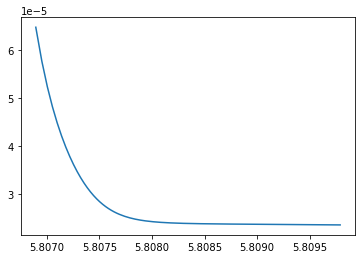

In [137]:
#plt.plot(av_array,abs(np.array(diff_array)))
plt.plot(av_array1, abs(np.array(diff_array1)))

[[5.80881386 5.80881174 5.80885211 ... 5.80885211 5.80881174 5.80881386]
 [5.80881597 5.90885692 5.90889729 ... 5.90889729 5.90885692 5.80881597]
 [5.80885211 5.90889306 5.90893343 ... 5.90893343 5.90889306 5.80885211]
 ...
 [5.80885211 5.90889306 5.90893343 ... 5.90893343 5.90889306 5.80885211]
 [5.80881597 5.90885692 5.90889729 ... 5.90889729 5.90885692 5.80881597]
 [5.80881386 5.80881174 5.80885211 ... 5.80885211 5.80881174 5.80881386]]


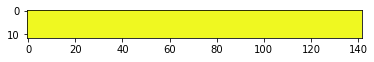

5.891974979128386 0.08218318884314701


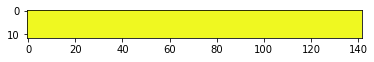

5.906936548995966 0.014961569867580238


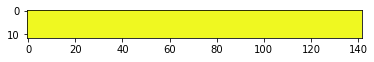

5.90694915250577 1.2603509803810198e-05


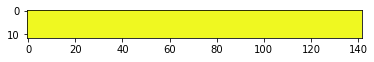

5.906959067181381 9.91467561117787e-06


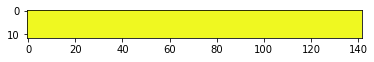

5.906968119307448 9.052126067388144e-06


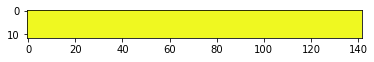

5.906976767662728 8.648355279916586e-06


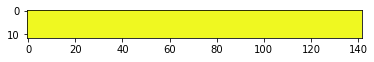

5.9069851889715475 8.421308819173134e-06


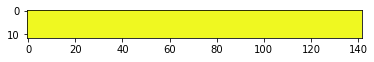

5.906993467565584 8.278594036958964e-06


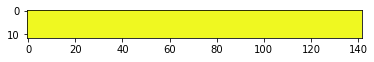

5.907001649295688 8.181730103196116e-06


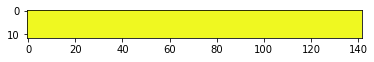

5.907009761354017 8.112058329068361e-06


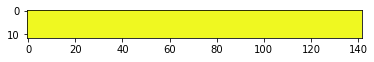

5.907017820905006 8.059550989258923e-06


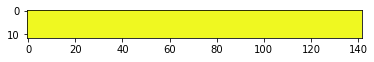

5.907025839330985 8.018425979194888e-06


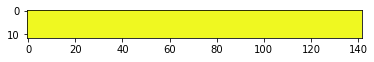

5.907033824512177 7.98518119182745e-06


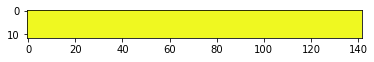

5.907041782126397 7.957614220011067e-06


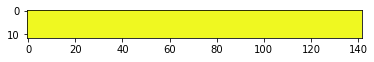

5.907049716421439 7.934295042311135e-06


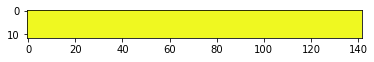

5.9070576306861 7.914264660513481e-06


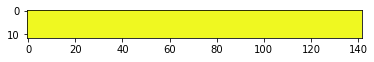

5.907065527544867 7.896858766898163e-06


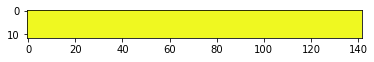

5.907073409145494 7.881600627257512e-06


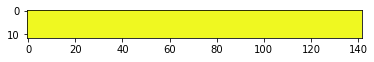

5.907081277281522 7.868136028044148e-06


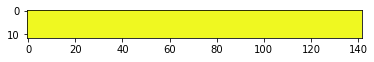

5.907089133474138 7.856192616451096e-06


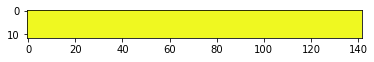

5.907096979028674 7.845554535812482e-06


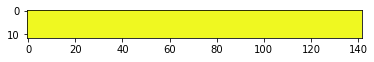

5.907104815074775 7.836046100884175e-06


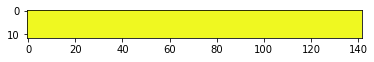

5.907112642596225 7.827521449677022e-06


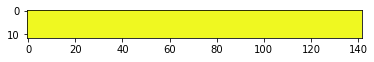

5.907120462453318 7.81985709341626e-06


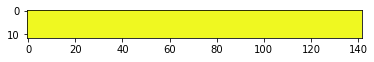

5.907128275400712 7.812947393937009e-06


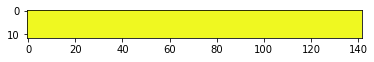

5.9071360821019105 7.806701198376231e-06


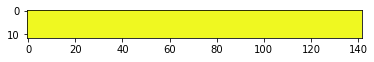

5.9071438831410905 7.801039179966551e-06


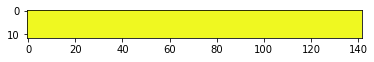

5.907151679033109 7.795892018158668e-06


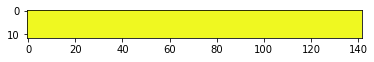

5.907159470232082 7.791198973094993e-06


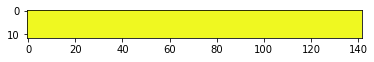

5.907167257138752 7.786906670581573e-06


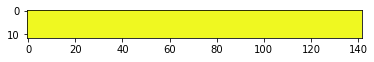

5.907175040106863 7.782968110880972e-06


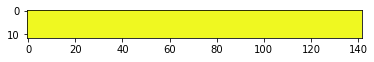

5.907182819448803 7.779341939517792e-06


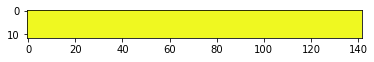

5.9071905954403965 7.775991593739207e-06


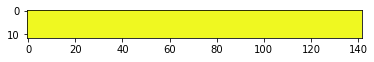

5.907198368325309 7.772884912604638e-06


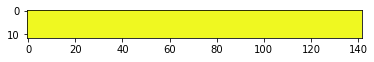

5.907206138318744 7.769993435324807e-06


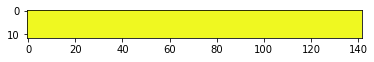

5.907213905610852 7.76729210727467e-06


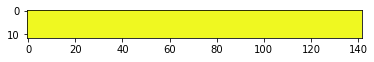

5.907221670369535 7.76475868313753e-06


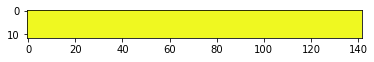

5.907229432743243 7.762373708253278e-06


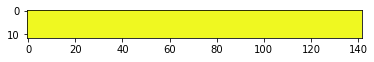

5.907237192863031 7.760119787647568e-06


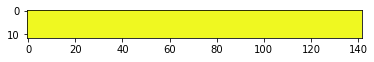

5.907244950844781 7.757981750344811e-06


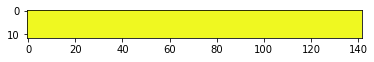

5.907252706790767 7.755945985898904e-06


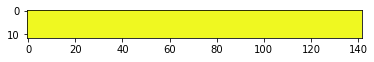

5.907260460791487 7.754000719728538e-06


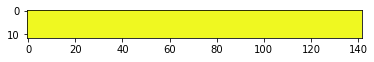

5.907268212926822 7.75213533543706e-06


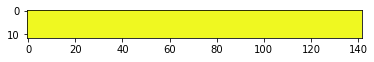

5.9072759632673755 7.750340553336343e-06


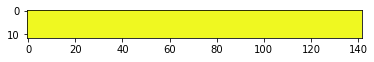

5.907283711875591 7.748608215507602e-06


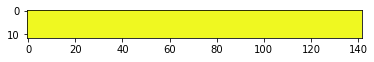

5.90729145880658 7.746930989149803e-06


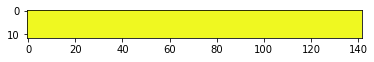

5.907299204109093 7.745302513129104e-06


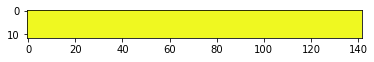

5.9073069478262115 7.743717118202653e-06


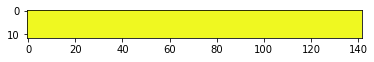

5.907314689996024 7.742169812807731e-06


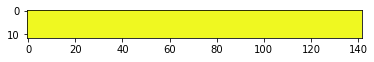

5.907322430652187 7.740656163157666e-06


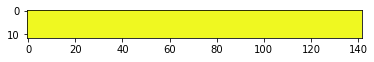

5.907330169824454 7.739172266596483e-06


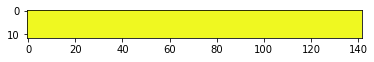

5.907337907539127 7.737714672551022e-06


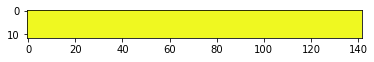

5.907345643819522 7.736280395853612e-06


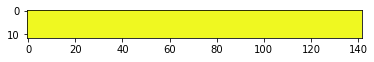

5.907353378686169 7.734866646735838e-06


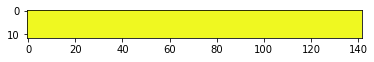

5.907361112157312 7.733471142579162e-06


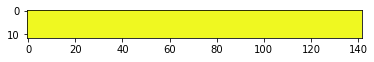

5.907368844249038 7.732091725998202e-06


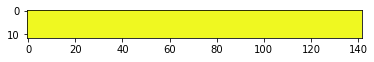

5.907376574975546 7.73072650783746e-06


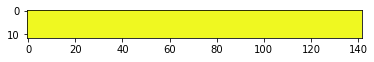

5.9073843043495335 7.729373987963584e-06


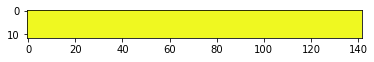

5.907392032382143 7.728032609399804e-06


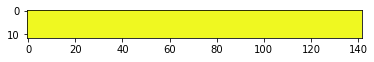

5.907399759083229 7.72670108606377e-06


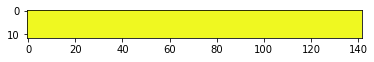

5.907407484461568 7.7253783388187e-06


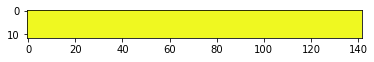

5.907415208524892 7.724063324054953e-06


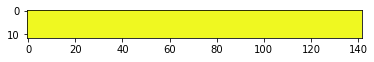

5.907422931280141 7.722755249517377e-06


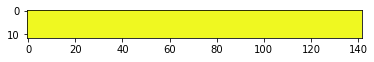

5.907430652733351 7.721453209263984e-06


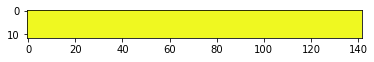

5.9074383728899695 7.720156618873375e-06


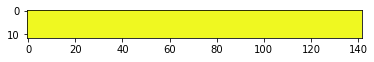

5.907446091754786 7.718864816652626e-06


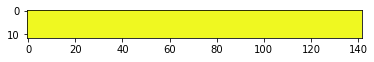

5.907453809332105 7.7175773185445e-06


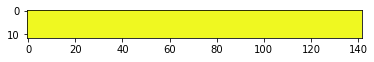

5.907461525625666 7.716293561443877e-06


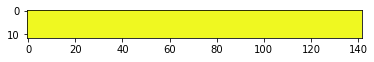

5.9074692406388944 7.715013228271062e-06


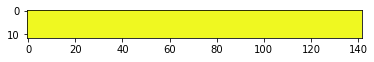

5.907476954374762 7.713735867831417e-06


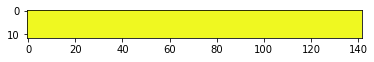

5.907484666835962 7.712461199460563e-06


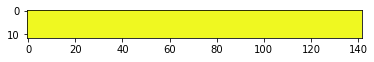

5.907492378024859 7.711188897197019e-06


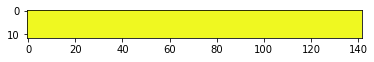

5.907500087943629 7.709918770082425e-06


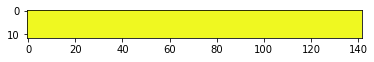

5.907507796594189 7.70865055965686e-06


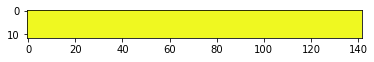

5.907515503978196 7.707384007460405e-06


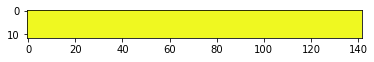

5.907523210097217 7.706119021122504e-06


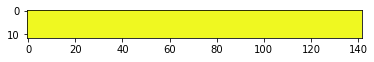

5.907530914952653 7.70485543544197e-06


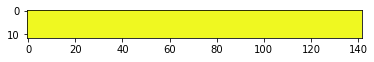

5.907538618545699 7.703593046137769e-06


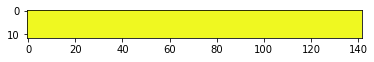

5.907546320877506 7.70233180702462e-06


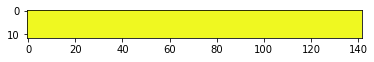

5.907554021949069 7.70107156355948e-06


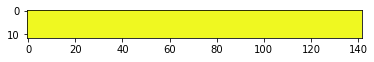

5.907561721761355 7.699812285544283e-06


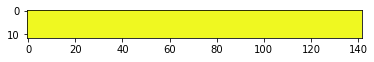

5.90756942031515 7.698553795343344e-06


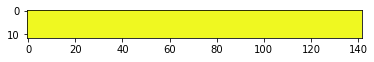

5.907577117611232 7.697296081410343e-06


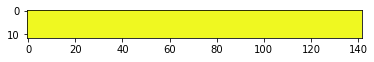

5.907584813650283 7.696039051374726e-06


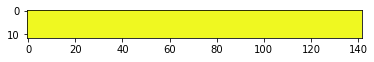

5.907592508432963 7.694782679479317e-06


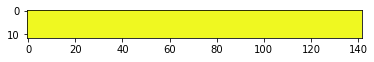

5.90760020195988 7.693526917762483e-06


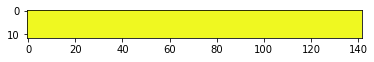

5.907607894231538 7.692271657866456e-06


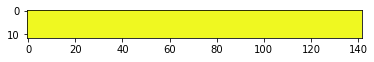

5.907615585248458 7.69101692021934e-06


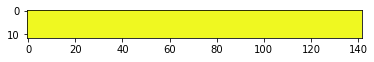

5.907623275011119 7.689762660412214e-06


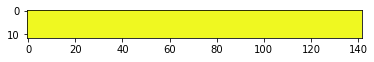

5.907630963519944 7.688508825154372e-06


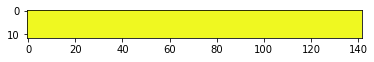

5.907638650775351 7.687255407340388e-06


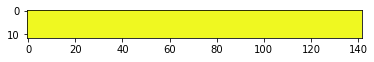

5.9076463367777095 7.686002358120447e-06


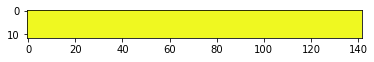

5.907654021527401 7.684749691705406e-06


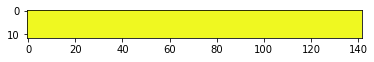

5.907661705024773 7.683497371679948e-06


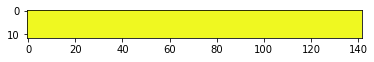

5.907669387270136 7.682245363405116e-06


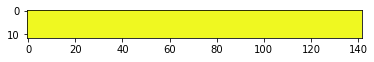

5.907677068263826 7.680993689973548e-06


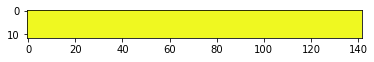

5.907684748006156 7.679742330068962e-06


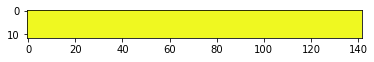

5.907692426497374 7.678491217966155e-06


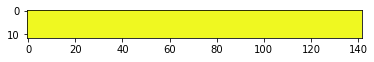

5.9077001037378 7.677240425607579e-06


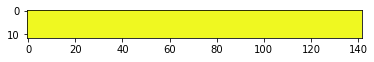

5.907707779727675 7.675989874833533e-06


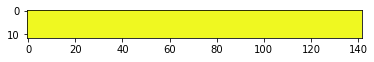

5.907715454467273 7.674739598506619e-06


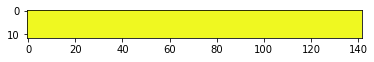

5.907723127956868 7.67348959485048e-06


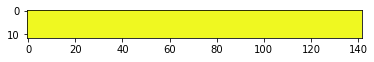

5.907730800196657 7.672239789258128e-06


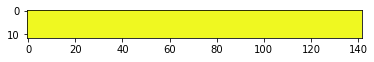

5.907738471186974 7.670990316732684e-06


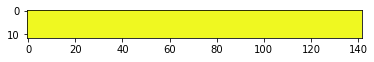

5.907746140927956 7.669740981874895e-06


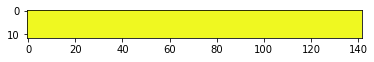

5.907753809419913 7.668491956991375e-06


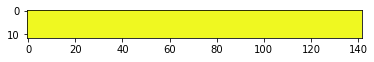

5.907761476663039 7.66724312573075e-06


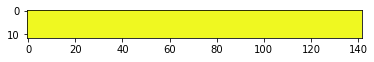

5.907769142657581 7.665994542271903e-06


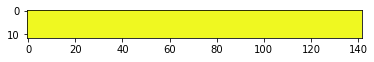

5.907776807403749 7.664746168423164e-06


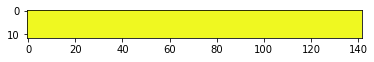

5.907784470901778 7.663498029053528e-06


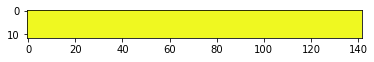

5.907792133151865 7.662250086859501e-06


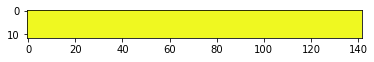

5.907799794154268 7.661002403125394e-06


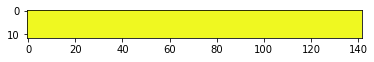

5.907807453909169 7.659754900579685e-06


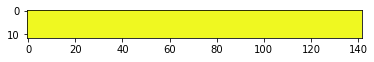

5.9078151124167935 7.658507624519473e-06


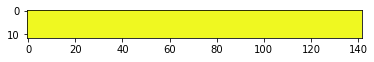

5.907822769677329 7.657260535864907e-06


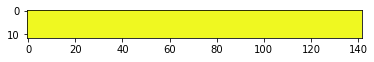

5.907830425691051 7.656013721657473e-06


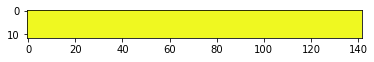

5.907838080458094 7.654767043341337e-06


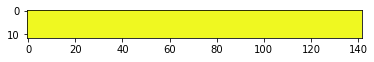

5.907845733978727 7.653520632366906e-06


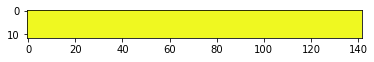

5.90785338625314 7.652274413239013e-06


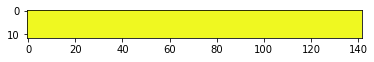

5.907861037281522 7.651028382404945e-06


In [138]:
T_k_updated = T_k_updated+0.1

for i in range(30000):
    T_k_updated, T_0_updated = update_with_source(T_k_updated, T_0_updated, q, 1e-4)
    if i == 0:
        print(T_k_updated)
    if i%250 == 0:
        fig, ax = plt.subplots()
        im = ax.imshow(T_k_updated, cmap='plasma', vmin=1, vmax=5)
        plt.show()
        #fig.suptitle('Temperature map')
        #cbar = ax.figure.colorbar(im, orientation='horizontal')
        #cbar.ax.set_xlabel('Temperature Scale')
        #plt.show()
        avT_k = sum(T_k_updated.ravel().A1)/(len(T_k_updated)*len(T_k_updated[1].A1))
        diff = avT_k-avT_k_1
        print(avT_k, diff)
        avT_k_1 = avT_k
    if i%100 == 0 and i >= 2000:
        diff_array1.append(diff)
        av_array1.append(avT_k)



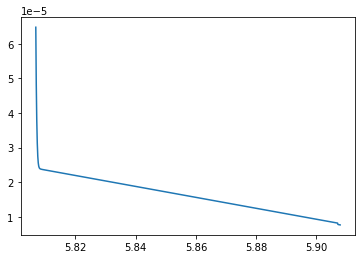

In [139]:
#plt.plot(av_array,abs(np.array(diff_array)))
plt.plot(av_array1, abs(np.array(diff_array1)))

[[5.95452021 5.95451802 5.95455997 ... 5.95455997 5.95451802 5.95452021]
 [5.95452241 5.95356497 5.95360693 ... 5.95360693 5.95356497 5.95452241]
 [5.95455997 5.95360254 5.95364449 ... 5.95364449 5.95360254 5.95455997]
 ...
 [5.95455997 5.95360254 5.95364449 ... 5.95364449 5.95360254 5.95455997]
 [5.95452241 5.95356497 5.95360693 ... 5.95360693 5.95356497 5.95452241]
 [5.95452021 5.95451802 5.95455997 ... 5.95455997 5.95451802 5.95452021]]


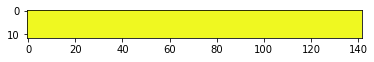

5.954739241754861 -0.0008216165709580281


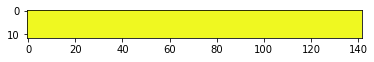

5.954589732520256 -0.00014950923460421706


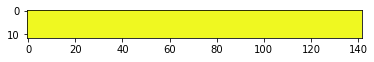

5.954589712989938 -1.953031869561528e-08


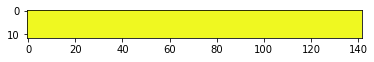

5.954589720413466 7.423528458616602e-09


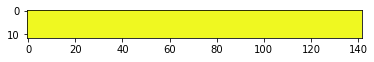

5.954589736517214 1.6103747668694268e-08


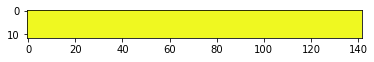

5.954589756704201 2.0186987192971628e-08


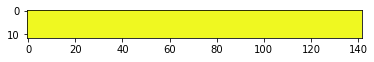

5.9545897791993365 2.249513553209681e-08


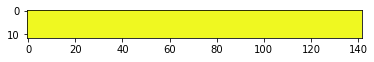

5.954589803152591 2.3953254491004827e-08


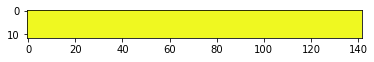

5.954589828099644 2.4947053312018852e-08


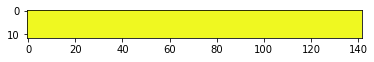

5.9545898537634585 2.5663814184895273e-08


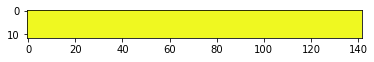

5.9545898799679495 2.6204491021530885e-08


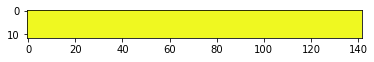

5.954589906595411 2.6627461124917318e-08


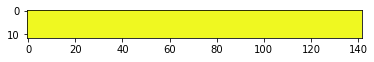

5.954589933563629 2.6968218769241048e-08


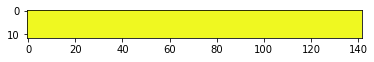

5.954589960812789 2.7249159373354814e-08


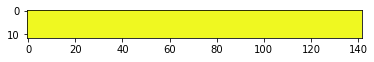

5.954589988297757 2.748496807924994e-08


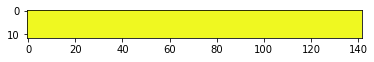

5.954590015983316 2.7685558734447113e-08


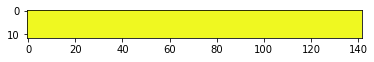

5.954590043841124 2.7857808504450077e-08


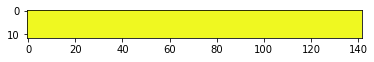

5.954590071847927 2.8006803098890032e-08


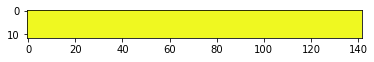

5.954590099984147 2.8136219576424537e-08


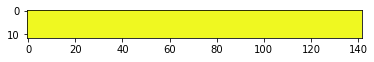

5.954590128233162 2.8249015571191194e-08


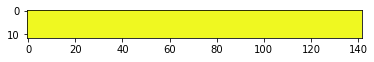

5.95459015658067 2.834750745250858e-08


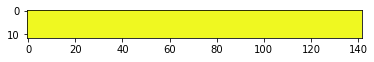

5.954590185014262 2.8433592369481175e-08


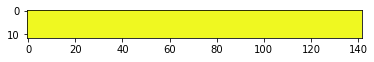

5.954590213523095 2.8508832627949232e-08


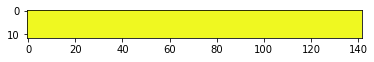

5.954590242097748 2.857465286609795e-08


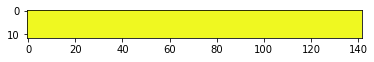

5.954590270729884 2.863213666159936e-08


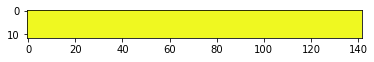

5.954590299412164 2.868227966246195e-08


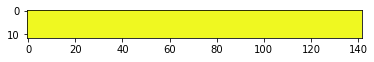

5.954590328138248 2.8726083733943142e-08


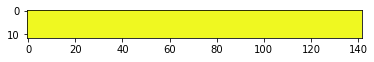

5.954590356902377 2.8764128856550997e-08


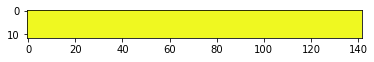

5.95459038569955 2.879717353465594e-08


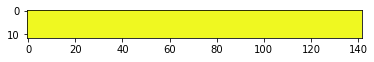

5.9545904145253665 2.882581640051285e-08


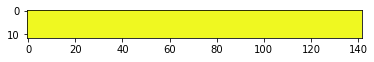

5.954590443375972 2.885060546020668e-08


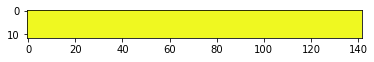

5.954590472247834 2.8871862234325363e-08


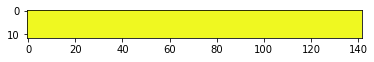

5.954590501138022 2.8890188019659035e-08


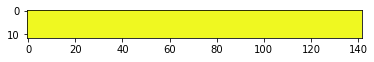

5.954590530043767 2.8905744464680083e-08


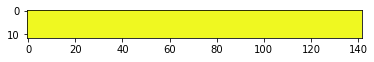

5.954590558962741 2.8918973882241517e-08


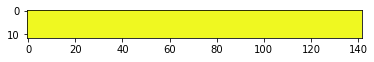

5.954590587892787 2.8930046802599918e-08


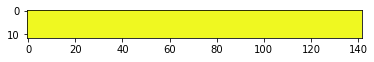

5.9545906168321245 2.893933714886998e-08


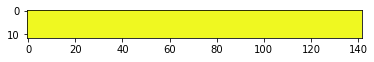

5.954590645779129 2.8947004793167253e-08


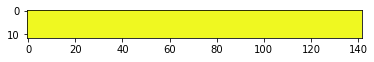

5.954590674732302 2.895317230411365e-08


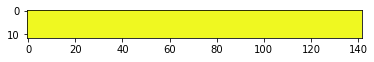

5.954590703690405 2.8958103470699825e-08


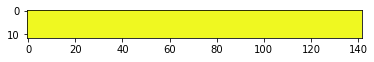

5.9545907326522824 2.896187734080513e-08


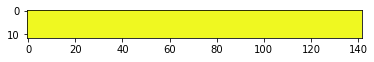

5.954590761616945 2.896466266832931e-08


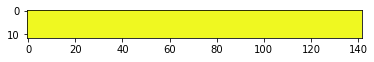

5.954590790583563 2.896661754903107e-08


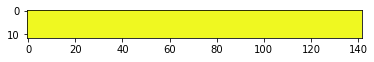

5.9545908195512975 2.8967734877483053e-08


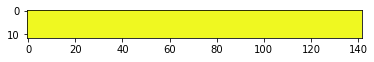

5.9545908485195165 2.896821893472179e-08


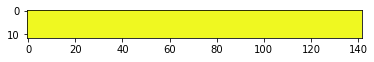

5.954590877487558 2.896804129903785e-08


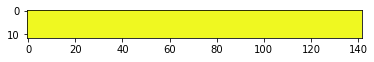

5.954590906454938 2.8967380494293593e-08


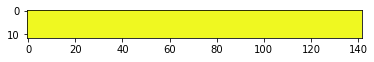

5.954590935421154 2.8966216092385366e-08


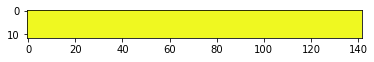

5.954590964385821 2.896466622104299e-08


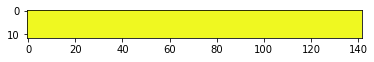

5.954590993348503 2.896268203045338e-08


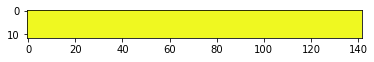

5.95459102230895 2.8960447373549414e-08


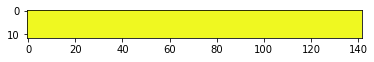

5.9545910512668385 2.8957888531522258e-08


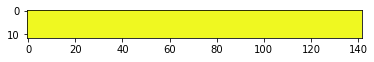

5.954591080221932 2.895509343403546e-08


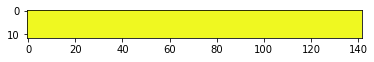

5.9545911091739825 2.895205053476957e-08


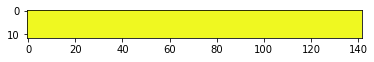

5.954591138122803 2.894882022985712e-08


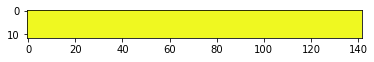

5.9545911670682266 2.8945423835580186e-08


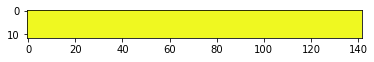

5.954591196010111 2.894188444457768e-08


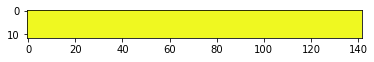

5.954591224948307 2.8938195839600667e-08


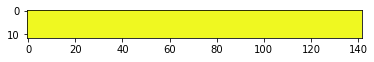

5.95459125388266 2.8934353579757044e-08


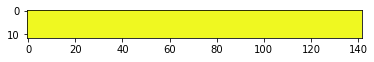

5.954591282813122 2.8930461581921918e-08


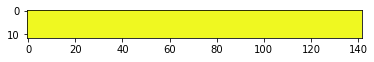

5.954591311739556 2.8926433692788578e-08


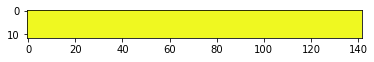

5.954591340661892 2.89223365257385e-08


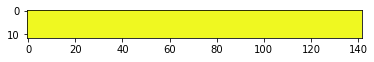

5.954591369580057 2.891816475170117e-08


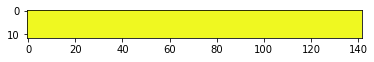

5.954591398494003 2.8913945904207594e-08


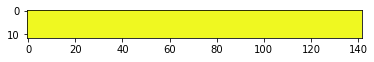

5.954591427403662 2.890965955515412e-08


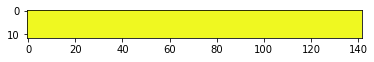

5.954591456308981 2.8905318139038627e-08


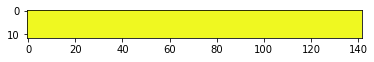

5.954591485209931 2.8900950077570542e-08


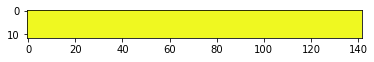

5.954591514106433 2.8896502080044684e-08


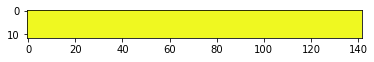

5.954591542998498 2.889206562883828e-08


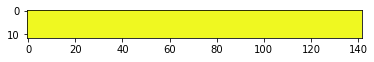

5.954591571886039 2.888754035978991e-08


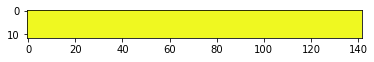

5.95459160076912 2.8883081704123015e-08


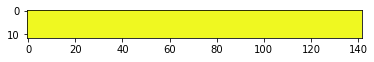

5.954591629647654 2.887853334243573e-08


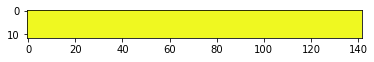

5.954591658521647 2.8873992974354223e-08


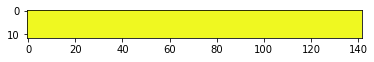

5.954591687391016 2.8869369117501265e-08


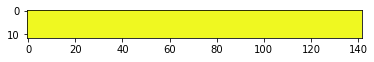

5.954591716255829 2.8864812762208203e-08


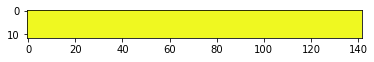

5.954591745116003 2.886017469450053e-08


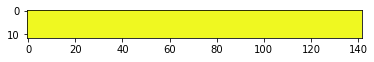

5.954591773971612 2.885560856924485e-08


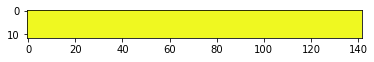

5.954591802822589 2.8850976718786114e-08


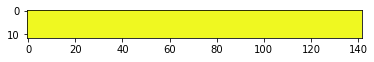

5.954591831668896 2.884630756483375e-08


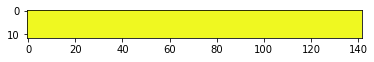

5.954591860510574 2.8841677490731854e-08


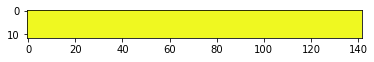

5.954591889347593 2.8837018994920527e-08


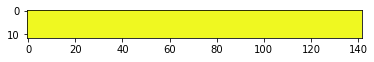

5.954591918179994 2.8832401355316506e-08


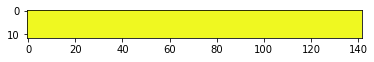

5.954591947007691 2.8827696674227354e-08


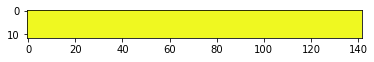

5.954591975830728 2.8823037290237608e-08


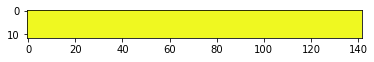

5.954592004649104 2.881837612989102e-08


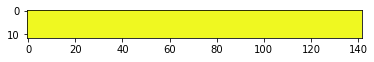

5.954592033462806 2.881370164686814e-08


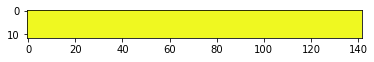

5.954592062271825 2.880901917023948e-08


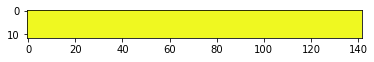

5.954592091076137 2.880431182461507e-08


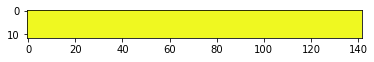

5.954592119875789 2.8799652440625323e-08


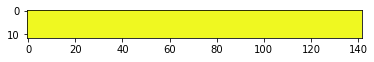

5.9545921486707645 2.8794975293067182e-08


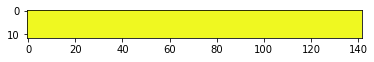

5.954592177461046 2.8790281270119067e-08


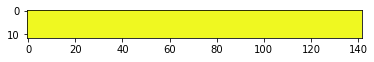

5.954592206246663 2.878561744523722e-08


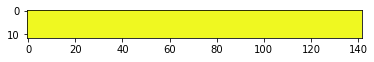

5.954592235027567 2.8780903882363873e-08


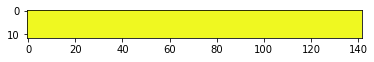

5.954592263803776 2.8776208971237338e-08


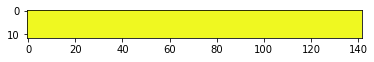

5.954592292575315 2.8771538929106555e-08


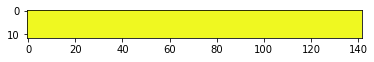

5.95459232134214 2.8766825366233206e-08


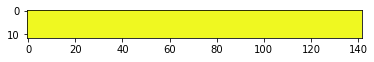

5.954592350104305 2.876216509406504e-08


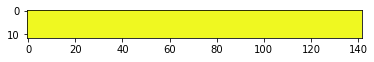

5.954592378861758 2.875745241937011e-08


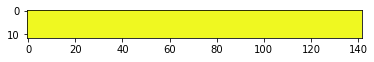

5.95459240761451 2.8752752179173058e-08


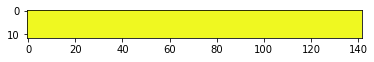

5.954592436362592 2.8748082137042275e-08


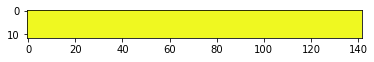

5.9545924651059705 2.8743378344131543e-08


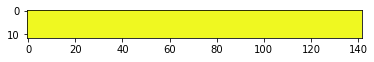

5.954592493844695 2.8738724289212314e-08


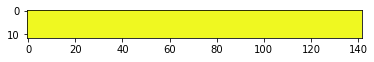

5.954592522578673 2.8733977863737437e-08


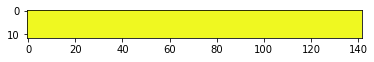

5.954592551307997 2.8729324696996628e-08


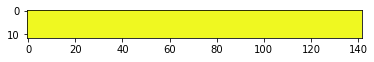

5.954592580032611 2.8724613798658538e-08


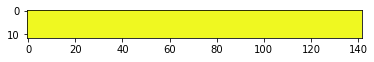

5.95459260875254 2.871992865749462e-08


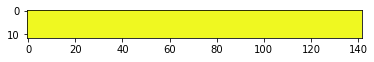

5.954592637467812 2.8715271938040132e-08


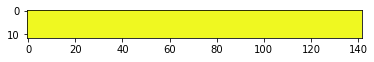

5.954592666178353 2.871054149977681e-08


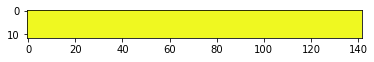

5.9545926948842345 2.8705881227608643e-08


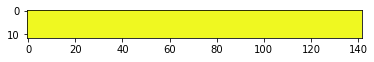

5.954592723585401 2.8701166776556875e-08


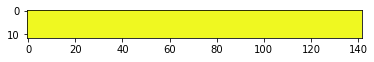

5.954592752281906 2.869650472803187e-08


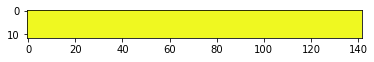

5.9545927809737185 2.8691812481440593e-08


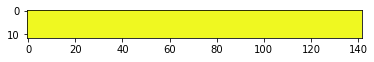

5.954592809660838 2.8687119346670897e-08


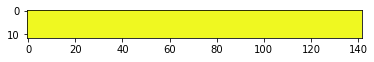

5.954592838343304 2.868246617993009e-08


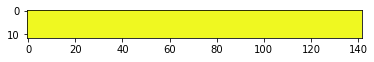

5.954592867021048 2.8677743735272543e-08


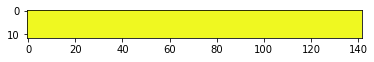

5.954592895694126 2.8673078134033858e-08


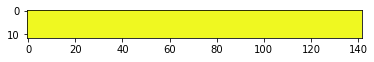

5.954592924362514 2.866838855197784e-08


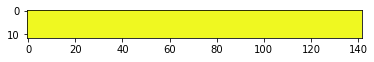

5.954592953026222 2.8663707851706022e-08


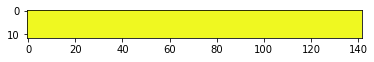

5.954592981685253 2.865903070414788e-08


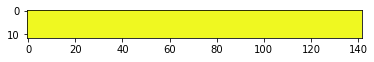

5.954593010339592 2.8654339345735025e-08


In [144]:
T_k_updated = T_k_updated-0.001

for i in range(30000):
    T_k_updated, T_0_updated = update_with_source(T_k_updated, T_0_updated, q, 1e-4)
    if i == 0:
        print(T_k_updated)
    if i%250 == 0:
        fig, ax = plt.subplots()
        im = ax.imshow(T_k_updated, cmap='plasma', vmin=1, vmax=5)
        plt.show()
        #fig.suptitle('Temperature map')
        #cbar = ax.figure.colorbar(im, orientation='horizontal')
        #cbar.ax.set_xlabel('Temperature Scale')
        #plt.show()
        avT_k = sum(T_k_updated.ravel().A1)/(len(T_k_updated)*len(T_k_updated[1].A1))
        diff = avT_k-avT_k_1
        print(avT_k, diff)
        avT_k_1 = avT_k
    if i%100 == 0 and i >= 2000:
        diff_array1.append(diff)
        av_array1.append(avT_k)



In [147]:
1+(7e6/(1.13*30*(300)**(4/3)))**(3/4)

33.28884436314636